In [1]:
# dependencies import
from common_dependencies import *
from train_dependencies import *
import logging
logger = logging.getLogger('main.06v_train.ipynb')

2024-03-13 22:14:01.068333: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: FFT
2024-03-13 22:14:01.107430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 22:14:01.581595: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: DNN


In [2]:
# paths for files with original data
PATH_TO_DATA = {
    'run_1': 
        ('data/original_data/run_1/run1_WM32_data.csv',
        'data/original_data/run_1/run1_WM32_defects.csv',
        'data/original_data/run_1/run1_WM32_pipe.csv'),
    'run_2':
        ('data/original_data/run_2/run2_WM32_data.csv',
        'data/original_data/run_2/run2_WM32_defects.csv',
        'data/original_data/run_2/run2_WM32_pipe.csv')
}

CROP_SIZE = 32
CROP_STEP = 10
PART_OF_DATA = 200

# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)
np.random.seed(290)

In [3]:
data = {}
x_df, y_df = dw.get_x_and_y_data(*PATH_TO_DATA['run_1'])
data['run_1'] = {'x_df': x_df, 'y_df': y_df}

#x_df, y_df = dw.get_x_and_y_data(*PATH_TO_DATA['run_2'])
#data['run_2'] = {'x_df': x_df, 'y_df': y_df}

main.custom_modules.data_worker.data_worker ::     get_x_and_y_data() :: 
    Read detectors data shape: (115, 400)
    Read defect data shape: (115, 400)


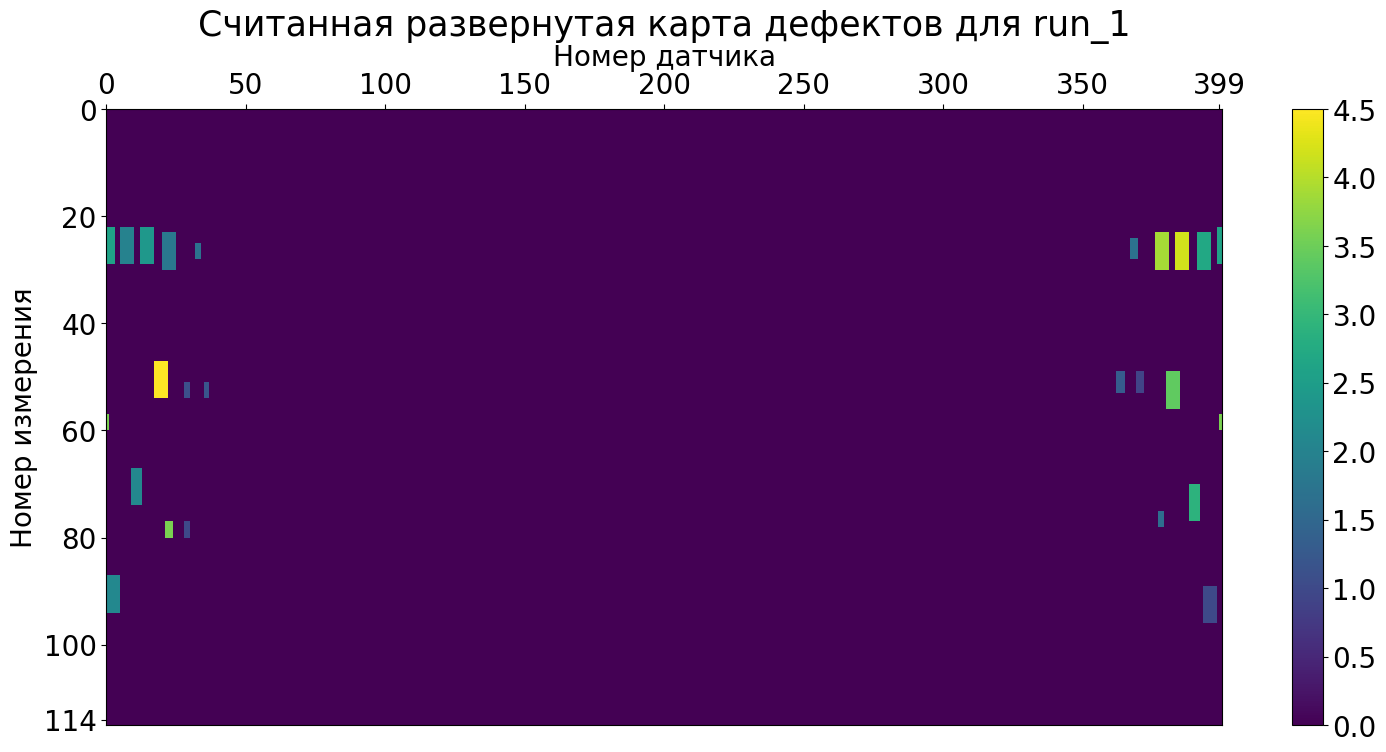

In [4]:
for run, value in data.items():
    dw.draw_defects_map(value['y_df'], title=f'Считанная развернутая карта дефектов для {run}')
    #dw.draw_zeros_quantity_in_data_df(value['x_df'], 
    #                                  title=f'Кол-во 0 значений в считанном датафрейме из данных детекторов для {run}')

In [5]:
# Take the first left half of each file as train and val dataset
#for run, value in data.items():
#    logger.debug('/'*8, run,'/'*8)
#    for data_part_name, data_part in value.items():
#        logger.debug(f'{data_part_name} original shape: {value[data_part_name].shape}', end=' -> ')
#        value[data_part_name] = value[data_part_name].iloc[:,:PART_OF_DATA]
#        logger.debug(f'sliced shape: {value[data_part_name].shape}')
#    

#logger.debug(f"run_1.x_df original shape: {data['run_1']['x_df'].shape}")
#logger.debug(f"run_1.y_df original shape: {data['run_1']['y_df'].shape}")
#data['run_1']['x_df'] = data['run_1']['x_df'].iloc[:,:PART_OF_DATA]
#data['run_1']['y_df'] = data['run_1']['y_df'].iloc[:,:PART_OF_DATA]
#logger.debug(f"run_1.x_df sliced shape: {data['run_1']['x_df'].shape}")
#logger.debug(f"run_1.y_df sliced shape: {data['run_1']['y_df'].shape}")

#

#logger.debug(f"run_2.x_df original shape: {data['run_2']['x_df'].shape}")
#logger.debug(f"run_2.y_df original shape: {data['run_2']['y_df'].shape}")
#data['run_2']['x_df'] = data['run_2']['x_df'].iloc[:,-PART_OF_DATA:]
#data['run_2']['y_df'] = data['run_2']['y_df'].iloc[:,-PART_OF_DATA:]
#logger.debug(f"run_2.x_df sliced shape: {data['run_2']['x_df'].shape}")
#logger.debug(f"run_2.y_df sliced shape: {data['run_2']['y_df'].shape}")

In [6]:
# extend dfs for better prediction and for crops dividing
for run, value in data.items():
    logger.debug('/'*8 + run + '/'*8)
    for data_part_name, data_part in value.items():
        logger.debug(data_part_name)
        value[data_part_name] = dw.extend_df_for_prediction(value[data_part_name], crop_size=CROP_SIZE)
        value[data_part_name] = dw.extend_df_for_crops_dividing(value[data_part_name], 
                                                                crop_size=CROP_SIZE, 
                                                                crop_step=CROP_STEP)

main.06v_train.ipynb ::             <module>() :: ////////run_1////////
main.06v_train.ipynb ::             <module>() :: x_df
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_prediction() :: 
    The input df shape: (177, 462)
    The crop size: 32
    The output df shape: (177, 462)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_crops_dividing() :: 
    The input df shape: (182, 462)
    The crop size: 32
    The crop step: 10
    The output df shape: (182, 462)
main.06v_train.ipynb ::             <module>() :: y_df
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_prediction() :: 
    The input df shape: (177, 462)
    The crop size: 32
    The output df shape: (177, 462)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_crops_dividing() :: 
    The input df shape: (182, 462)
    The crop size: 32
    The crop step: 10
    The output df shape: (182, 462)


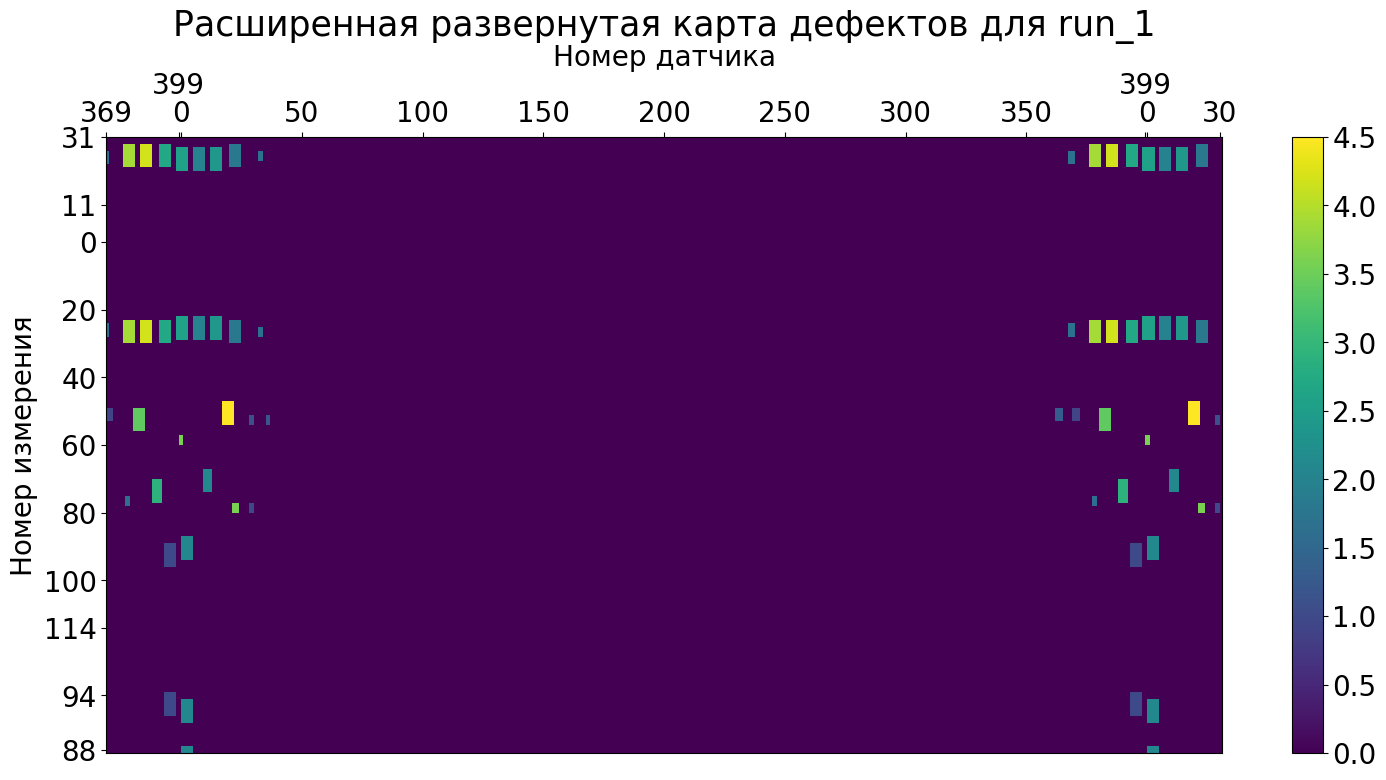

In [7]:
for run, value in data.items():
    dw.draw_defects_map(value['y_df'], title=f'Расширенная развернутая карта дефектов для {run}')

In [8]:
# преобразовать данные к виду (измерение, размер х, размер у, каналы)
# для x_data_time каналы = 32
# для x_data_amp каналы = 32
# для y_data каналы = 1
for run, value in data.items():
    logger.debug('/'*8 + run + '/'*8)
    (x_data_time,
    x_data_amp) = dw.reshape_x_df_to_image_like_numpy(value['x_df'], CROP_SIZE, CROP_STEP)
    value['time_arr'] = x_data_time
    value['amp_arr'] = x_data_amp
    y_data = dw.reshape_y_df_to_image_like_numpy(value['y_df'], CROP_SIZE, CROP_STEP)
    value['mask_arr'] = y_data
    del value['x_df']
    del value['y_df']

main.06v_train.ipynb ::             <module>() :: ////////run_1////////
main.custom_modules.data_worker.data_worker :: reshape_x_df_to_image_like_numpy() :: 
    The input df shape: (182, 462)
    The crop size: 32
    The crop step: 10
    The output time array of crops shape: (704, 32, 32, 32)
    The output amplitude array of crops shape: (704, 32, 32, 32)
main.custom_modules.data_worker.data_worker :: reshape_y_df_to_image_like_numpy() :: 
    The input df shape: (182, 462)
    The crop size: 32
    The crop step: 10
    The output defect depth array of crops shape: (704, 32, 32, 1)


In [9]:
# нормализовать входные данные
for run, value in data.items():
    logger.debug('/'*8 + run + '/'*8)
    value['time_arr'] = dw.standardize_data(value['time_arr'])
    value['amp_arr'] = dw.standardize_data(value['amp_arr'])

main.06v_train.ipynb ::             <module>() :: ////////run_1////////
main.custom_modules.data_worker.data_worker ::     standardize_data() :: 
    The arr max before standardization: 44.5
    The arr min before standardization: 0.0
    The arr max after standardization: 1.0
    The arr min after standardization: 0.0
main.custom_modules.data_worker.data_worker ::     standardize_data() :: 
    The arr max before standardization: 62.992
    The arr min before standardization: -61.968
    The arr max after standardization: 1.0
    The arr min after standardization: -0.983743967487935


In [10]:
# Поделить кропы на дефектные и нет
for run, value in data.items():
    logger.debug('/'*8 + run + '/'*8)
    (x_time_def, x_time_non_def), \
    (x_amp_def, x_amp_non_def), \
    (y_mask_def, y_mask_non_def) = dw.split_def_and_non_def_data(value['time_arr'], 
                                                                 value['amp_arr'], 
                                                                 value['mask_arr'], CROP_SIZE)
    value['def_time_arr'] = x_time_def
    value['non_def_time_arr'] = x_time_non_def
    
    value['def_amp_arr'] = x_amp_def
    value['non_def_amp_arr'] = x_amp_non_def
    
    value['def_mask_arr'] = y_mask_def
    value['non_def_mask_arr'] = y_mask_non_def
    
    del value['time_arr']
    del value['amp_arr']
    del value['mask_arr']

main.06v_train.ipynb ::             <module>() :: ////////run_1////////
main.custom_modules.data_worker.data_worker :: _calculate_crops_with_defects_positions() :: 
    For 704 crops of size: 32
    there are 159 defect crops
main.custom_modules.data_worker.data_worker :: split_def_and_non_def_data() :: 
    The input time array of crops shape: (704, 32, 32, 32)
    The input amplitude array of crops shape: (704, 32, 32, 32)
    The input defect depth array of crops shape: (704, 32, 32, 1)
    The output time array of crops refer to defects shape: (159, 32, 32, 32)
    The output time array of crops do not refer to defects shape: (545, 32, 32, 32)
    The output amplitude array of crops refer to defects shape: (159, 32, 32, 32)
    The output amplitude array of crops do not refer to defects shape: (545, 32, 32, 32)
    The output defect depth array of crops refer to defects shape: (159, 32, 32, 1)
    The output defect depth array of crops do not refer to defects shape: (545, 32, 32, 1

In [11]:
# take only certain part of non_defect data
for run, value in data.items():
    logger.debug('/'*8 + run + '/'*8)
    shuffled_indices = np.random.permutation(value['non_def_time_arr'].shape[0])
    shuffled_indices = shuffled_indices[:value['def_time_arr'].shape[0]*2]
    
    value['non_def_time_arr'] = value['non_def_time_arr'][shuffled_indices]
    value['non_def_amp_arr'] = value['non_def_amp_arr'][shuffled_indices]
    value['non_def_mask_arr'] = value['non_def_mask_arr'][shuffled_indices]

    for data_part_name, data_part in value.items():
        logger.debug(f'{data_part_name}: {data_part.shape}')


main.06v_train.ipynb ::             <module>() :: ////////run_1////////
main.06v_train.ipynb ::             <module>() :: def_time_arr: (159, 32, 32, 32)
main.06v_train.ipynb ::             <module>() :: non_def_time_arr: (318, 32, 32, 32)
main.06v_train.ipynb ::             <module>() :: def_amp_arr: (159, 32, 32, 32)
main.06v_train.ipynb ::             <module>() :: non_def_amp_arr: (318, 32, 32, 32)
main.06v_train.ipynb ::             <module>() :: def_mask_arr: (159, 32, 32, 1)
main.06v_train.ipynb ::             <module>() :: non_def_mask_arr: (318, 32, 32, 1)


In [12]:
# Аугментировать данные
for run, value in data.items():
    logger.debug('/'*8 + run + '/'*8)
    for data_part_name, data_part in value.items():
        logger.debug(data_part_name)
        value[data_part_name] = dw.augment_data(value[data_part_name])  

main.06v_train.ipynb ::             <module>() :: ////////run_1////////
main.06v_train.ipynb ::             <module>() :: def_time_arr
main.custom_modules.data_worker.data_worker ::         augment_data() :: 
    The input array of crops shape: {arr.shape}
    The array after 4 steps of 90 degree rotation: (636, 32, 32, 32)
    The array after horizontal full mirroring: (1272, 32, 32, 32)
    The array after vertical full mirroring: (2544, 32, 32, 32)
main.06v_train.ipynb ::             <module>() :: non_def_time_arr
main.custom_modules.data_worker.data_worker ::         augment_data() :: 
    The input array of crops shape: {arr.shape}
    The array after 4 steps of 90 degree rotation: (1272, 32, 32, 32)
    The array after horizontal full mirroring: (2544, 32, 32, 32)
    The array after vertical full mirroring: (5088, 32, 32, 32)
main.06v_train.ipynb ::             <module>() :: def_amp_arr
main.custom_modules.data_worker.data_worker ::         augment_data() :: 
    The input array

In [13]:
# создание выходных данных бинарного вида (одномерный массив типа bool)
for run, value in data.items():


    logger.debug('/'*8 + run + '/'*8)
    logger.debug('/'*8 + 'def_vals' + '/'*8)
    value['def_binary_arr'] = dw.create_binary_arr_from_mask_arr(value['def_mask_arr'])
    value['def_depth_arr'] =  dw.standardize_data(dw.create_depth_arr_from_mask_arr(value['def_mask_arr']))

    logger.debug('/'*8 + 'non_def_vals' + '/'*8)
    value['non_def_binary_arr'] = dw.create_binary_arr_from_mask_arr(value['non_def_mask_arr'])
    value['non_def_depth_arr'] = dw.standardize_data(dw.create_depth_arr_from_mask_arr(value['non_def_mask_arr']))
                                                     
    del value['def_mask_arr']
    del value['non_def_mask_arr']

main.06v_train.ipynb ::             <module>() :: ////////run_1////////
main.06v_train.ipynb ::             <module>() :: ////////def_vals////////
main.custom_modules.data_worker.data_worker :: create_binary_arr_from_mask_arr() :: 
    The input defect depth array of crops shape: (2544, 32, 32, 1)
    The output flat defect binary array shape: (2544, 32, 32, 1)
main.custom_modules.data_worker.data_worker :: create_depth_arr_from_mask_arr() :: 
    The input defect depth array of crops shape: (2544, 32, 32, 1)
    The output flat defect depth array shape: (2544, 32, 32, 1)
main.custom_modules.data_worker.data_worker ::     standardize_data() :: 
    The arr max before standardization: 4.5
    The arr min before standardization: 1.0
    The arr max after standardization: 1.0
    The arr min after standardization: 0.2222222238779068
main.06v_train.ipynb ::             <module>() :: ////////non_def_vals////////
main.custom_modules.data_worker.data_worker :: create_binary_arr_from_mask_arr(

In [14]:
# деление на тренировочную и валидационную выборки

val_data_percent = 0

X_time_train, X_time_val = dw.split_data_to_train_val_datasets([data['run_1']['def_time_arr'],
                                                                data['run_1']['non_def_time_arr']],
                                                                val_data_percent)
del data['run_1']['def_time_arr']
del data['run_1']['non_def_time_arr']
#del data['run_2']['def_time_arr']
#del data['run_2']['non_def_time_arr']

X_amp_train, X_amp_val = dw.split_data_to_train_val_datasets([data['run_1']['def_amp_arr'],
                                                              data['run_1']['non_def_amp_arr']],
                                                              val_data_percent)
del data['run_1']['def_amp_arr']
del data['run_1']['non_def_amp_arr']
#del data['run_2']['def_amp_arr']
#del data['run_2']['non_def_amp_arr']

Y_binary_train, Y_binary_val = dw.split_data_to_train_val_datasets([data['run_1']['def_binary_arr'],
                                                                   data['run_1']['non_def_binary_arr']],
                                                                   val_data_percent)
del data['run_1']['def_binary_arr']
del data['run_1']['non_def_binary_arr']
#del data['run_2']['def_binary_arr']
#del data['run_2']['non_def_binary_arr']

Y_depth_train, Y_depth_val = dw.split_data_to_train_val_datasets([data['run_1']['def_depth_arr'],
                                                                   data['run_1']['non_def_depth_arr']],
                                                                   val_data_percent)
del data['run_1']['def_depth_arr']
del data['run_1']['non_def_depth_arr']

data = None

main.custom_modules.data_worker.data_worker :: split_data_to_train_val_datasets() :: 
    The input array shapes: [(2544, 32, 32, 32), (5088, 32, 32, 32)]
    The output train array shape: (7632, 32, 32, 32)
    The output validation array shape: (0, 32, 32, 32)
main.custom_modules.data_worker.data_worker :: split_data_to_train_val_datasets() :: 
    The input array shapes: [(2544, 32, 32, 32), (5088, 32, 32, 32)]
    The output train array shape: (7632, 32, 32, 32)
    The output validation array shape: (0, 32, 32, 32)
main.custom_modules.data_worker.data_worker :: split_data_to_train_val_datasets() :: 
    The input array shapes: [(2544,), (5088,)]
    The output train array shape: (7632,)
    The output validation array shape: (0,)
main.custom_modules.data_worker.data_worker :: split_data_to_train_val_datasets() :: 
    The input array shapes: [(2544,), (5088,)]
    The output train array shape: (7632,)
    The output validation array shape: (0,)


In [15]:
# перемешивание данных
train_shuffled_indices = np.random.permutation(X_time_train.shape[0])
val_shuffled_indices = np.random.permutation(X_time_val.shape[0])

X_time_train = X_time_train[train_shuffled_indices]
X_amp_train = X_amp_train[train_shuffled_indices]
Y_binary_train = Y_binary_train[train_shuffled_indices]
Y_depth_train = Y_depth_train[train_shuffled_indices]

X_time_val = X_time_val[val_shuffled_indices]
X_amp_val = X_amp_val[val_shuffled_indices]
Y_binary_val = Y_binary_val[val_shuffled_indices]
Y_depth_val = Y_depth_val[val_shuffled_indices]

In [16]:
logger.debug(f'{X_time_train.shape=}')
logger.debug(f'{X_amp_train.shape=}')
logger.debug(f'{Y_binary_train.shape=}')
logger.debug(f'{Y_depth_train.shape=}\n')

logger.debug(f'{X_time_val.shape=}')
logger.debug(f'{X_amp_val.shape=}')
logger.debug(f'{Y_binary_val.shape=}')
logger.debug(f'{Y_depth_val.shape=}')

main.06v_train.ipynb ::             <module>() :: X_time_train.shape=(7632, 32, 32, 32)
main.06v_train.ipynb ::             <module>() :: X_amp_train.shape=(7632, 32, 32, 32)
main.06v_train.ipynb ::             <module>() :: Y_binary_train.shape=(7632,)
main.06v_train.ipynb ::             <module>() :: Y_depth_train.shape=(7632,)

main.06v_train.ipynb ::             <module>() :: X_time_val.shape=(0, 32, 32, 32)
main.06v_train.ipynb ::             <module>() :: X_amp_val.shape=(0, 32, 32, 32)
main.06v_train.ipynb ::             <module>() :: Y_binary_val.shape=(0,)
main.06v_train.ipynb ::             <module>() :: Y_depth_val.shape=(0,)


In [17]:
# всякие константы для последующей работы

#///////////////////////////////// для компиляции 

CMP_learning_rate = 0.000008 #0.0000002 # шаг сходимости back propogation
CMP_solver = keras.optimizers.Adam(CMP_learning_rate) # оптимизатор
#CMP_solver = keras.optimizers.SGD(CMP_learning_rate) # оптимизатор
CMP_loss_func = 'mean_squared_error'# функция потерь
#///////////////////////////////// для колбэков

    # для Early_stopping
ES_patience = 3 # кол-во эпох без улучшений
ES_min_delta = 0.00001 # минимальное улучшение параметра за cur_patience
ES_monitor_parametr =  'loss' # отслеживаемый параметр 
ES_save_best_weights = True # сохранять ли веса нейронки с лучшими результатами
    
    # для ReduceLROnPlateau
RLPOP_monitor_parametr = 'loss'  # отслеживаемый параметр 
RLPOP_factor = 0.2 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
RLPOP_patience = 1 # кол-во эпох без улучшений
RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
RLPOP_min_delta = 0.0005 # порог изменения отслеживаемого значения
RLPOP_cooldown = 3 # количество эпох до возобновления работы после изменения шага сходимости
RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
#///////////////////////////////// для тренировки

FIT_batch_size = 10 # размер bach при обучении/тестировании1
#FIT_shuffle = True # перемешивать ли данные
FIT_verbose = True # выводить ли прогресс обучения в его процессее
FIT_epochs = 60 # количество эпох обучения
#FIT_validation_split = 0.10 #0.20 # процент валидационных данных, отсекаемых из тестовой выборки

2024-03-13 22:14:09.827582: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-13 22:14:09.854161: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-13 22:14:09.854217: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-13 22:14:09.855534: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-13 22:14:09.855607: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

In [18]:
# создание архитектуры модели
# 1 подсеть //////////////////////////////////////////////////
input_time = Input((32,32,32), name = 'input_time')

dconv_1_1 = Conv2D(128, (5,5), activation='relu', padding='same', name='dconv_1_1')(input_time)

dconv_1_2 = Conv2D(128, (5,5), dilation_rate=(4, 4), activation='relu', name='dconv_1_2')(input_time)
up_1_2 = UpSampling2D(2, interpolation='bilinear', name='up_1_2') (dconv_1_2)

dconv_1_3 = Conv2D(128, (5,5), dilation_rate=(6, 6), activation='relu', name='dconv_1_3')(input_time)
up_1_3 = UpSampling2D(4, interpolation='bilinear', name='up_1_3') (dconv_1_3)

dconv_1_4 = Conv2D(128, (5,5), dilation_rate=(7, 7), activation='relu', name='dconv_1_4')(input_time)
up_1_4 = UpSampling2D(8, interpolation='bilinear', name='up_1_4') (dconv_1_4)

conc_1_1 = concatenate([dconv_1_1, up_1_2, up_1_3, up_1_4], axis=3, name='conc_1_1')

conv_1_1 = Conv2D(128, (2,2), activation='relu', name='conv_1_1', padding='same')(conc_1_1)
conv_1_2 = Conv2D(128, (2,2), activation='relu', name='conv_1_2', padding='same')(conv_1_1)
conv_1_3 = Conv2D(128, (2,2), activation='relu', name='conv_1_3', padding='same')(conv_1_2)
pool_1_1 = MaxPooling2D((2,2), strides=2, name='pool_1_1')(conv_1_3)

conv_1_4 = Conv2D(256, (2,2), activation='relu', name='conv_1_4', padding='same')(pool_1_1)
conv_1_5 = Conv2D(256, (2,2), activation='relu', name='conv_1_5', padding='same')(conv_1_4)
conv_1_6 = Conv2D(256, (2,2), activation='relu', name='conv_1_6', padding='same')(conv_1_5)
pool_1_2 = MaxPooling2D((2,2), strides=2, name='pool_1_2')(conv_1_6)

# 2 подсеть //////////////////////////////////////////////////
input_amp = Input((32,32,32), name = 'input_amp')

dconv_2_1 = Conv2D(128, (5,5), activation='relu', padding='same', name='dconv_2_1')(input_amp)

dconv_2_2 = Conv2D(128, (5,5), dilation_rate=(4, 4), activation='relu', name='dconv_2_2')(input_amp)
up_2_2 = UpSampling2D(2, interpolation='bilinear', name='up_2_2') (dconv_2_2)

dconv_2_3 = Conv2D(128, (5,5), dilation_rate=(6, 6), activation='relu', name='dconv_2_3')(input_amp)
up_2_3 = UpSampling2D(4, interpolation='bilinear', name='up_2_3') (dconv_2_3)

dconv_2_4 = Conv2D(128, (5,5), dilation_rate=(7, 7), activation='relu', name='dconv_2_4')(input_amp)
up_2_4 = UpSampling2D(8, interpolation='bilinear', name='up_2_4') (dconv_2_4)

conc_2_1 = concatenate([dconv_2_1, up_2_2, up_2_3, up_2_4], axis=3, name='conc_2_1')

conv_2_1 = Conv2D(128, (2,2), activation='relu', name='conv_2_1', padding='same')(conc_2_1)
conv_2_2 = Conv2D(128, (2,2), activation='relu', name='conv_2_2', padding='same')(conv_2_1)
conv_2_3 = Conv2D(128, (2,2), activation='relu', name='conv_2_3', padding='same')(conv_2_2)
pool_2_1 = MaxPooling2D((2,2), strides=2, name='pool_2_1')(conv_2_3)

conv_2_4 = Conv2D(256, (2,2), activation='relu', name='conv_2_4', padding='same')(pool_2_1)
conv_2_5 = Conv2D(256, (2,2), activation='relu', name='conv_2_5', padding='same')(conv_2_4)
conv_2_6 = Conv2D(256, (2,2), activation='relu', name='conv_2_6', padding='same')(conv_2_5)
pool_2_2 = MaxPooling2D((2,2), strides=2, name='pool_2_2')(conv_2_6)

conc_2_2 = concatenate([pool_1_2, pool_2_2], axis=3, name='conc_2_2')

conv_3_1 = Conv2D(512, (2,2), activation='relu', name='conv_3_1', padding='same')(conc_2_2)
conv_3_2 = Conv2D(512, (2,2), activation='relu', name='conv_3_2', padding='same')(conv_3_1)
conv_3_3 = Conv2D(512, (2,2), activation='relu', name='conv_3_3', padding='same')(conv_3_2)
pool_3_1 = MaxPooling2D((2,2), strides=2, name='pool_3_1')(conv_3_3)

conv_3_4 = Conv2D(512, (2,2), activation='relu', name='conv_3_4', padding='same')(pool_3_1)
conv_3_5 = Conv2D(512, (2,2), activation='relu', name='conv_3_5', padding='same')(conv_3_4)
conv_3_6 = Conv2D(512, (2,2), activation='relu', name='conv_3_6', padding='same')(conv_3_5)
pool_3_2 = MaxPooling2D((2,2), strides=2, name='pool_3_2')(conv_3_6)

conv_3_7 = Conv2D(512, (2,2), activation='relu', name='conv_3_7', padding='same')(pool_3_2)
conv_3_8 = Conv2D(512, (2,2), activation='relu', name='conv_3_8', padding='same')(conv_3_7)
conv_3_9 = Conv2D(512, (2,2), activation='relu', name='conv_3_9', padding='same')(conv_3_8)
pool_3_3 = MaxPooling2D((2,2), strides=2, name='pool_3_3')(conv_3_9)

# выходная подсеть по наличию дефекта //////////////////////////////////////////////////

flat_3_1 = Flatten(name='flat_3_1')(pool_3_3)

d_3_1 = Dense(2048, activation='linear', name='d_3_1')(flat_3_1)
d_3_2 = Dense(1024, activation='linear', name='d_3_2')(d_3_1)
d_3_3 = Dense(128, activation='linear', name='d_3_3')(d_3_2)
d_3_4 = Dense(32, activation='linear', name='d_3_4')(d_3_3)

output_def_bool = Dense(1, activation='sigmoid', name='output_3_1')(d_3_4)

# выходная подсеть по глубине дефекта //////////////////////////////////////////////////

d_4_1 = Dense(2048, activation='linear', name='d_4_1')(flat_3_1)
d_4_2 = Dense(1024, activation='linear', name='d_4_2')(d_4_1)
d_4_3 = Dense(128, activation='linear', name='d_4_3')(d_4_2)
d_4_4 = Dense(32, activation='linear', name='d_4_4')(d_4_3)

output_def_depth = Dense(1, activation='tanh', name='output_4_1')(d_4_4)

model = keras.Model([input_time, input_amp], [output_def_bool, output_def_depth], name='model')

#model = keras.models.load_model(f"networks/CNN/id=v04n03_in(16x16+16x16)_out(1)_train=0dot0_test=0dot0.h5")

model.compile(optimizer=CMP_solver, loss=CMP_loss_func)

print(model.summary())

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_time          │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_amp           │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_1_2 (Conv2D)  │ (None, 16, 16,    │    102,528 │ input_time[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_1_3 (Conv2D)  │ (None, 8, 8, 128) │    102,528 │ input_time[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_1_4 (Conv2D)  │ (None, 4, 4, 128) │    102,528 │ input_time[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_2_2 (Conv2D)  │ (None, 16, 16,    │    102,528 │ input_amp[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_2_3 (Conv2D)  │ (None, 8, 8, 128) │    102,528 │ input_amp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_2_4 (Conv2D)  │ (None, 4, 4, 128) │    102,528 │ input_amp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_1_1 (Conv2D)  │ (None, 32, 32,    │    102,528 │ input_time[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_1_2              │ (None, 32, 32,    │          0 │ dconv_1_2[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_1_3              │ (None, 32, 32,    │          0 │ dconv_1_3[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_1_4              │ (None, 32, 32,    │          0 │ dconv_1_4[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_2_1 (Conv2D)  │ (None, 32, 32,    │    102,528 │ input_amp[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_2_2              │ (None, 32, 32,    │          0 │ dconv_2_2[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_2_3              │ (None, 32, 32,    │          0 │ dconv_2_3[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_2_4              │ (None, 32, 32,    │          0 │ dconv_2_4[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conc_1_1            │ (None, 32, 32,    │          0 │ dconv_1_1[0][0],  │
│ (Concatenate)       │ 512)              │            │ up_1_2[0][0],     │
│                     │                   │            │ up_1_3[0][0],     │
│                     │                   │            │ up_1_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 18,929,794 (72.21 MB)

 Trainable params: 18,929,794 (72.21 MB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(
    model,
    to_file="model_plot.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False,
)

In [20]:
# Создание и настройка колбэков

callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

temp = keras.callbacks.EarlyStopping(
            monitor = ES_monitor_parametr, 
            min_delta = ES_min_delta, 
            patience = ES_patience,
            restore_best_weights = ES_save_best_weights
            )
callback_list.append(temp)

temp = keras.callbacks.ReduceLROnPlateau(
            monitor = RLPOP_monitor_parametr, 
            factor = RLPOP_factor, 
            patience = RLPOP_patience, 
            verbose = RLPOP_verbose,
            mode = RLPOP_mode, 
            min_delta = RLPOP_min_delta, 
            cooldown = RLPOP_cooldown, 
            min_lr = RLPOP_min_lr
            )
callback_list.append(temp)

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = model
            )

In [21]:
history = model.fit([X_time_train, X_amp_train], [Y_binary_train, Y_depth_train],
                    batch_size = FIT_batch_size, 
                    epochs = FIT_epochs, 
                    verbose = FIT_verbose, 
                    #validation_data = ([X_time_val, X_amp_val], [Y_binary_val, Y_depth_val]), 
                    callbacks = FIT_callback_list)

2024-03-13 22:14:13.220797: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1000341504 exceeds 10% of free system memory.
2024-03-13 22:14:14.184094: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1000341504 exceeds 10% of free system memory.
2024-03-13 22:14:15.060607: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1000341504 exceeds 10% of free system memory.
2024-03-13 22:14:15.481142: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1000341504 exceeds 10% of free system memory.
I0000 00:00:1710342860.043978    5651 service.cc:145] XLA service 0x76d9f800dc40 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1710342860.044008    5651 service.cc:153]   StreamExecutor device (0): Radeon RX 7900 XT, AMDGPU ISA version: gfx1100


      5/Unknown 10s 15ms/step - loss: 0.4742

I0000 00:00:1710342866.162339    5651 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


764/764 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - loss: 0.3589 - learning_rate: 8.0000e-06
764/764 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.2725 - learning_rate: 8.0000e-06
764/764 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.1097 - learning_rate: 8.0000e-06
764/764 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0935 - learning_rate: 8.0000e-06
764/764 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0744 - learning_rate: 8.0000e-06
764/764 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0639 - learning_rate: 8.0000e-06
764/764 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0528 - learning_rate: 8.0000e-06
764/764 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0479 - learning_rate: 8.0000e-06
764/764 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0411 - learning_rate: 8.0000e-06
764/764 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0297 - learning_rate: 8.0000e-06
764/764 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0209 - learning_rate: 8.0000e-06
761/764 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.01

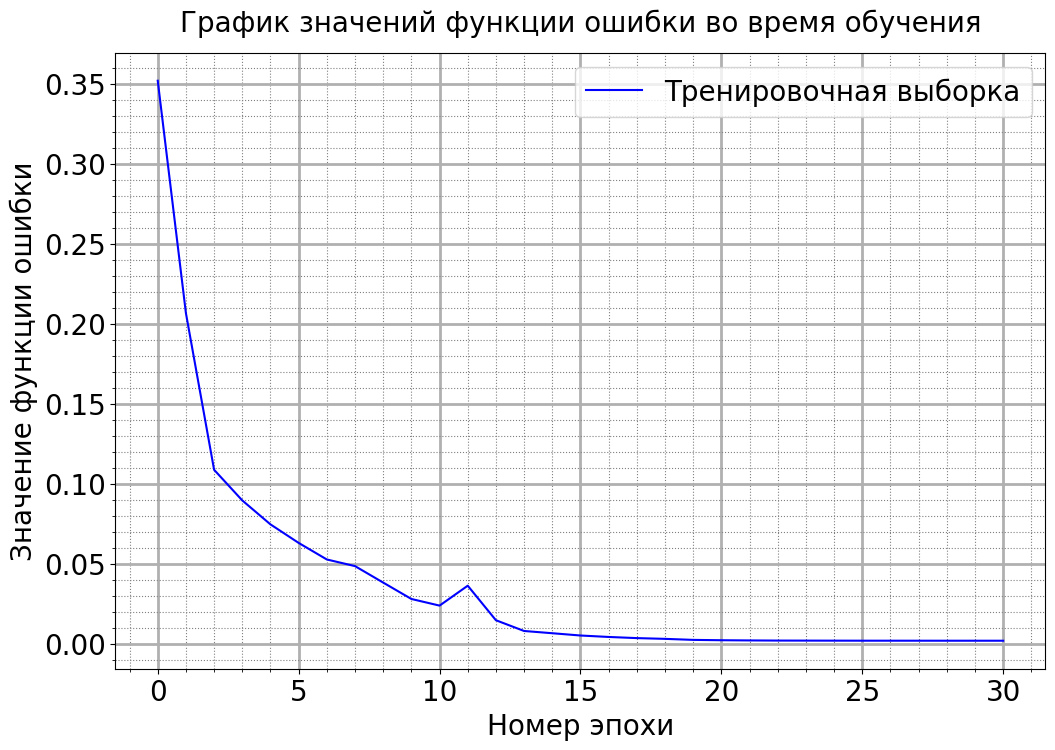

In [22]:
fig, ax = plt.subplots()

fig.set_figwidth(12)
fig.set_figheight(8)

plt.plot(history.history['loss'], 
         label='Тренировочная выборка',  linewidth=1.5, color='blue')
#plt.plot(history.history['val_loss'], linestyle = '--', 
#         label='Валидационная выборка',  linewidth=3, color='red')

ax.set_xlabel('Номер эпохи', fontsize=20)
ax.set_ylabel('Значение функции ошибки', fontsize=20)
ax.set_title(f"График значений функции ошибки во время обучения", fontsize=20, pad=15)

ax.patch.set_alpha(0)

#  Устанавливаем форматирование делений:
ax.tick_params(axis='both', which='both', labelsize = 20)

# Вывод и настройка сетки
ax.minorticks_on()
ax.grid(which='major', linewidth=2)
ax.grid(which='minor', color = 'gray', linestyle = ':')

ax.legend(fontsize = 20, facecolor = "white", loc = 'upper right')

plt.show()

In [23]:
# сохранение модели в файл
model.save(f"networks/CNN/id=v07n06_in(32x32+32x32)_out(1+1)_train=0dot0_test=0dot0.keras")

#### 